## Objective: Image Classification using Convolutional Neural Networks in PyTorch

### About the dataset: MNIST dataset consist of collection of handwritten digits, it has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.

### Reference: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/lesson/lesson-2-working-with-images-and-logistic-regression?notebook=aakashns/mnist-logistic-minimal

In [1]:
# Imports
import torch
import torchvision

In [2]:
# Download dataset
from torchvision.datasets import MNIST

dataset = MNIST(root='data/', download=True)
test_dataset = MNIST(root='data/', train=False)
len(dataset), len(test_dataset)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



(60000, 10000)

(<PIL.Image.Image image mode=L size=28x28 at 0x7F9CDDBC9EE0>, 5)
Label: 5


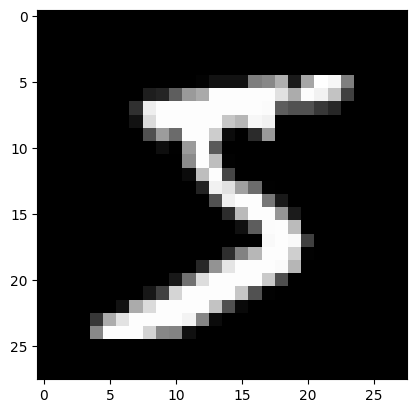

In [3]:
# displaying sample image from dataset
import matplotlib.pyplot as plt

image, label = dataset[0]
plt.imshow(image, cmap='gray')
print(dataset[0])
print('Label:', label)

In [4]:
import torchvision.transforms as transforms

# Since the above dataset is in PIL we convert it to tensor for input compatibility to model
# PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
dataset = MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

img_tensor, label = dataset[0]
print(img_tensor.shape, label)
print(dataset[0])

torch.Size([1, 28, 28]) 5
(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.00

In [5]:
# splitting dataset in training and validation dataset
from torch.utils.data import random_split

random_seed = 0
torch.manual_seed(random_seed)
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
# Splitting training and validation data into batches
from torch.utils.data import DataLoader

batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)

input_size = 28*28
num_classes = 10

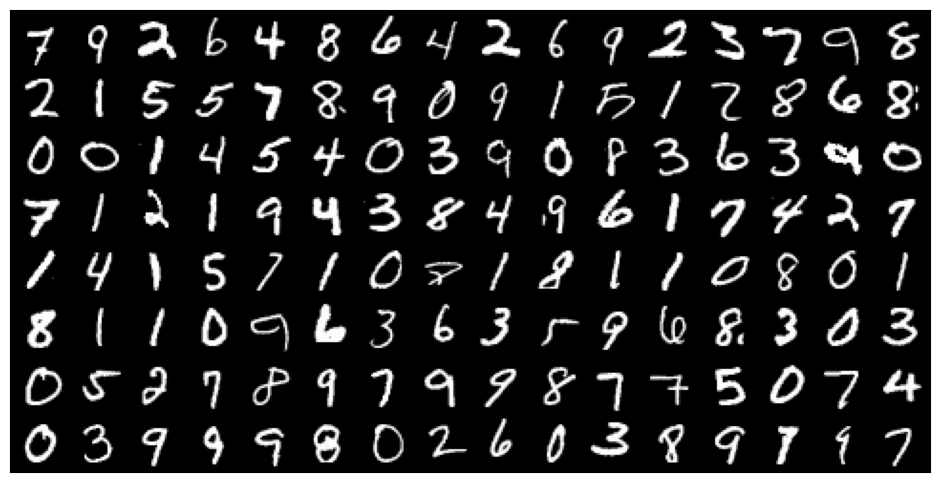

In [7]:
# displaying one batch of images
from torchvision.utils import make_grid

def show_batch(dl):
    for images, label in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

show_batch(train_dl)

In [8]:
# Defining accuracy metric
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
# Extenstion of nn.Module for model
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)    # Logistic regression model, # x * w.t() + b; w contains weight and b contains biases
        # logits are the vector of raw (non-normalized) predictions that a classification model generates
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)  # it goes to 'forward' inside MnistModel to flatten images and get output from model
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [10]:
# Evaluation function for validation set and testing set
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [11]:
# Training and Validation for number of epoch specified
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)   # Generate predictions and calculate loss
            loss.backward() # Compute gradients
            optimizer.step()    # Update weights
            optimizer.zero_grad()   # Reset gradients
        
        # Validation phase
        result = evaluate(model, val_loader) # Generate predictions and calculate loss
        model.epoch_end(epoch, result)  # Calculate metrics
        history.append(result)

    return history

In [12]:
# Evaluating validation set on model based on initialization
result0 = evaluate(model, val_dl)
result0

{'val_loss': 2.307511806488037, 'val_acc': 0.13686709105968475}

In [13]:
# Training the model
history1 = fit(20, 0.001, model, train_dl, val_dl)

Epoch [0], val_loss: 1.9368, val_acc: 0.6323
Epoch [1], val_loss: 1.6679, val_acc: 0.7312
Epoch [2], val_loss: 1.4683, val_acc: 0.7615
Epoch [3], val_loss: 1.3184, val_acc: 0.7794
Epoch [4], val_loss: 1.2032, val_acc: 0.7923
Epoch [5], val_loss: 1.1130, val_acc: 0.8050
Epoch [6], val_loss: 1.0406, val_acc: 0.8124
Epoch [7], val_loss: 0.9815, val_acc: 0.8193
Epoch [8], val_loss: 0.9322, val_acc: 0.8246
Epoch [9], val_loss: 0.8905, val_acc: 0.8286
Epoch [10], val_loss: 0.8549, val_acc: 0.8336
Epoch [11], val_loss: 0.8240, val_acc: 0.8371
Epoch [12], val_loss: 0.7969, val_acc: 0.8397
Epoch [13], val_loss: 0.7729, val_acc: 0.8425
Epoch [14], val_loss: 0.7516, val_acc: 0.8443
Epoch [15], val_loss: 0.7325, val_acc: 0.8469
Epoch [16], val_loss: 0.7152, val_acc: 0.8492
Epoch [17], val_loss: 0.6995, val_acc: 0.8501
Epoch [18], val_loss: 0.6852, val_acc: 0.8509
Epoch [19], val_loss: 0.6720, val_acc: 0.8524


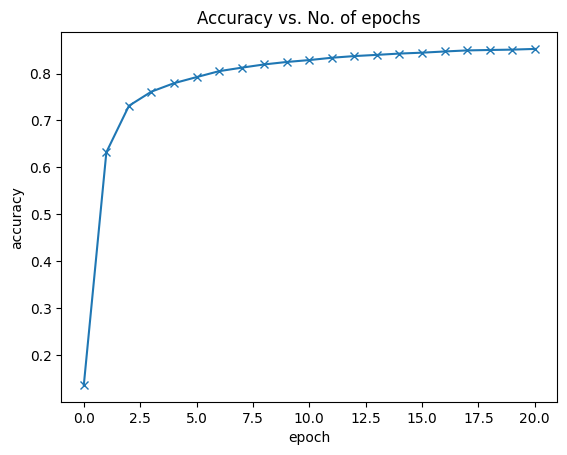

In [14]:
# Plotting accuracy vs epoch graph
history = [result0] + history1
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [15]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=transforms.ToTensor())

In [16]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 4 , Predicted: 0


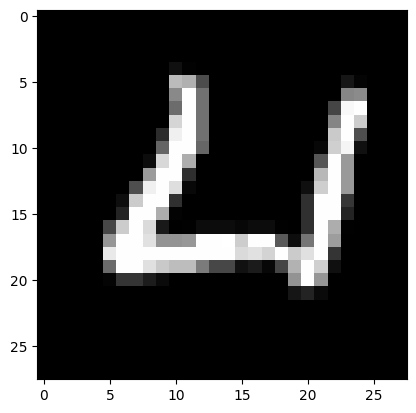

In [17]:
img, label = test_dataset[33]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 4 , Predicted: 4


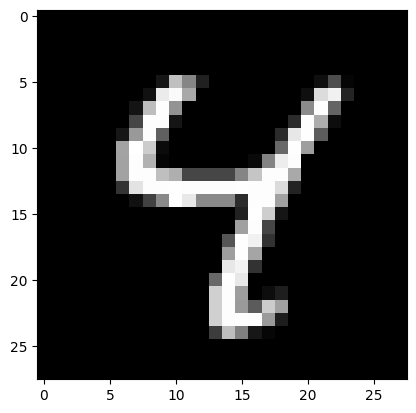

In [18]:
img, label = test_dataset[6]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [19]:
# Evaluating test set on final model
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model, test_loader)
result

{'val_loss': 0.6395356059074402, 'val_acc': 0.8624023199081421}